# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Fictitious Prediction Analysis</strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;"> 
This notebook contains analysis of synthetic data. At a high level, we use a basic generative model to generate a true polarization p in [.5,1]. From here we generate a sample of points (x_i, y_i), where u_i is the polarization of the individual, y_i is their political party, and $x_i$ is a sample speech. There are N such individuals for each of the T timesteps. The central idea of fictitious prediction is that the accuracy of predicting y_i given x_i.
</p>


# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Table of Contents </strong> </p>


<table style="margin-left: auto; margin-right: auto; width: 85%; border-collapse: collapse; font-family: 'Georgia', serif; font-size: 105%; border: 2px solid #333;">
    <tr>
        <td>No</td>
        <td>Contents</td>
        <td>No</td>
        <td>Contents</td>
    </tr>
    <tr>
        <td>1</td>
        <td><a href="#1"> FILL IN </a></td>
        <td>3</td>
        <td><a href="#3"> FILL IN</a></td>
    </tr>
    <tr>
        <td>2</td>
        <td><a href="#2">FILL IN</a></td>
        <td>4</td>
        <td><a href="#4">FILL IN</a></td>
    </tr>
</table>


In [1]:
import os 
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns 
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
SRC_PATH      = os.getcwd()
MAIN_PATH     = os.path.dirname(SRC_PATH)               
DATA_PATH     = f"{MAIN_PATH}/data"
CSV_FPATH     = f'{DATA_PATH}/results.csv'
PLOT_PATH     = f'{DATA_PATH}/plots'
PMETA_FPATH   = f'{DATA_PATH}/plot_metadata.json'

In [6]:
df = pd.read_csv(CSV_FPATH)
df.head()

,id,pop_size,lex_size,vocab_size,epsilon,speech_len,alpha,beta,a_mult,strength,num_folds,model,param_grid,scoring,rho,score
0,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.607041,0.592499
1,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.809037,0.183872
2,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.714433,0.370717
3,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.754468,0.319745
4,1,1000,10,30,0.05,15,3,3,2,2,5,GradientBoostingClassifier(),{},neg_log_loss,0.915356,0.086762


In [7]:
def plot(dataframe, x='rho', y='score', title=None, savefig=False, plot_desc=None, color_by='id'):
    df = dataframe.copy()
    scoring_map = {"accuracy": "Accuracy", "neg_log_loss": "Log Likelihood", "f1": "F1 Score"}

    scoring_name = scoring_map.get(df['scoring'].iloc[0], df['scoring'].iloc[0])
    y_label = scoring_name
    x_label = "Polarization"

    plot_title = title if title else f"{y_label} vs. {x_label}"
    plt.figure(figsize=(12,8))
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    if y_label == 'Log Likelihood':
        df['score'] = df['score'].apply(lambda x : -x) # flip score
    palette = sns.color_palette("husl", len(df[color_by].unique()))

    if df[color_by].nunique() > 1:
        ax = sns.scatterplot(x=x, y=y, hue=color_by, palette=palette, data=df)
    else:
        ax = sns.scatterplot(x=x, y=y, data=df)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(plot_title)

    if savefig:
        PLOT_PATH = os.path.join(os.getcwd(), 'plots')
        os.makedirs(PLOT_PATH, exist_ok=True)
        plot_file_path = os.path.join(PLOT_PATH, f"{plot_title}.jpg")
        plt.savefig(plot_file_path)

        # If plot description is provided, save it to metadata
        if plot_desc is not None:
            metadata = {}
            if os.path.exists(PMETA_FPATH):
                with open(PMETA_FPATH, 'r') as file:
                    metadata = json.load(file)
            metadata[plot_file_path] = plot_desc
            with open(PMETA_FPATH, 'w') as file:
                json.dump(metadata, file, indent=4)

    # 5) Create a box with other parameters
    if df[color_by].nunique() == 1:
        other_params = df.drop(['rho', 'score'], axis=1).iloc[0].to_dict()
        textstr = '\n'.join([f"{key} = {val}" for key, val in other_params.items()])
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

    plt.show()

## Population Size  

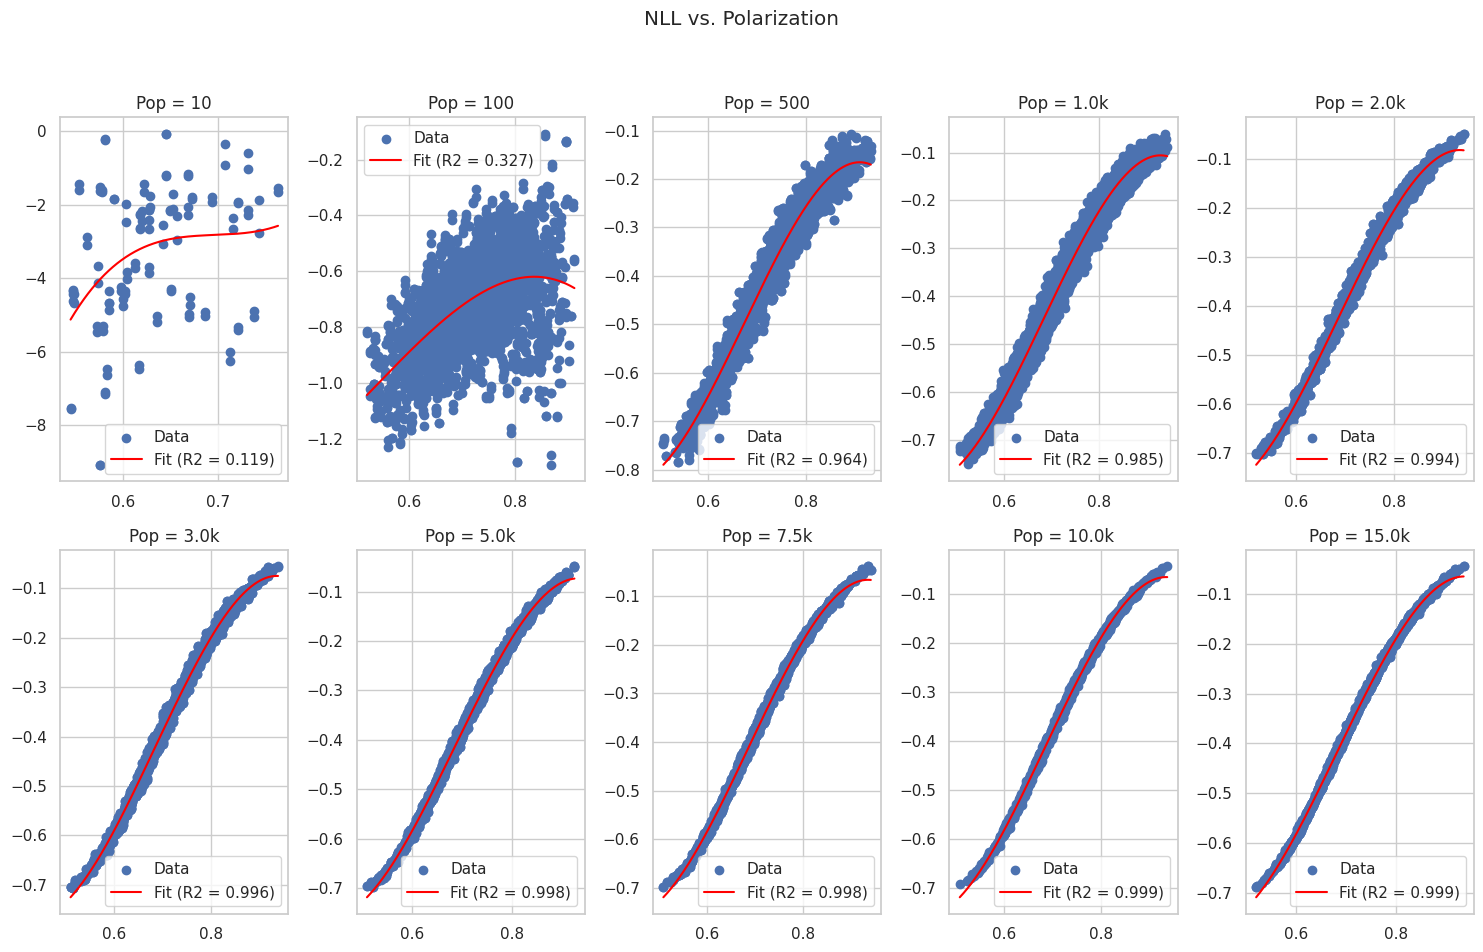

In [8]:
defaults = {
    "lex_size" : 10,
    'epsilon'  : 0.05,
    'alpha'    : 3,
    'beta'     : 3,
    'a_mult'   : 2,
    'scoring'  : 'neg_log_loss',
    'speech_len' : 15,
    'strength' : 2,
    'num_folds' : 5
}
pop_to_r2 = {}

def format_number(num):
    if num >= 1000000:
        return f"{num/1000000:.1f}m"
    elif num >= 1000:
        return f"{num/1000:.1f}k"
    else:
        return str(num)

sns.set(style="whitegrid")

# Number of unique population sizes
n_pop_sizes = len(df['pop_size'].unique())

# Creating a grid for subplots: 3 columns and required number of rows
n_cols = 5
n_rows = np.ceil(n_pop_sizes / n_cols).astype(int)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Flattening the axes array for easy iteration
axes = axes.flatten()

for i, pop_size in enumerate(sorted(df['pop_size'].unique())):
    ax = axes[i]
    condition = (df['pop_size'] == pop_size)
    for key, value in defaults.items():
        condition &= (df[key] == value)
    pop = df[condition].dropna(subset=['rho', 'score'])

    if not pop.empty:
        x = pop['rho'].values.reshape(-1, 1)
        y = pop['score'].values

        # Polynomial regression
        poly = PolynomialFeatures(3)
        x_poly = poly.fit_transform(x)
        model = LinearRegression()
        model.fit(x_poly, y)
        # Creating linspace for smooth curve
        x_linspace = np.linspace(x.min(), x.max(), 500).reshape(-1, 1)
        x_linspace_poly = poly.transform(x_linspace)
        y_linspace = model.predict(x_linspace_poly)
        y_pred = model.predict(x_poly)
        r2 = r2_score(y, y_pred)
        pop_to_r2[pop_size] = r2

        # Plotting
        ax.scatter(x, -y, label='Data')
        ax.plot(x_linspace, -y_linspace, color='red', label=f'Fit (R2 = {round(r2,3)})')
        ax.set_title(f'Pop = {format_number(pop_size)}')
        ax.legend()

# Set the main title for all subplots
plt.suptitle('NLL vs. Polarization')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Remove unused subplots if any
for j in range(i+1, n_cols * n_rows):
    fig.delaxes(axes[j])

plt.show()

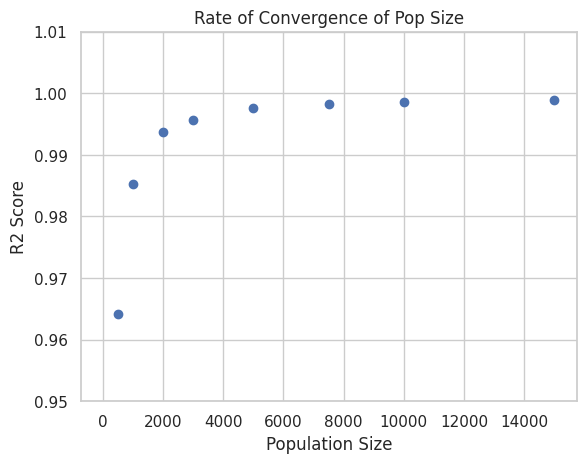

In [9]:
sns.set(style="whitegrid")
plt.scatter(pop_to_r2.keys(), pop_to_r2.values())

# Adjusting the y-axis to focus on the range of interest
plt.ylim(0.95, 1.01)  # Adjust this range based on your actual R2 scores

# Improving the format of the y-axis to show more detail
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.xlabel('Population Size')
plt.ylabel('R2 Score')
plt.title('Rate of Convergence of Pop Size')
plt.show()

# Epsilon

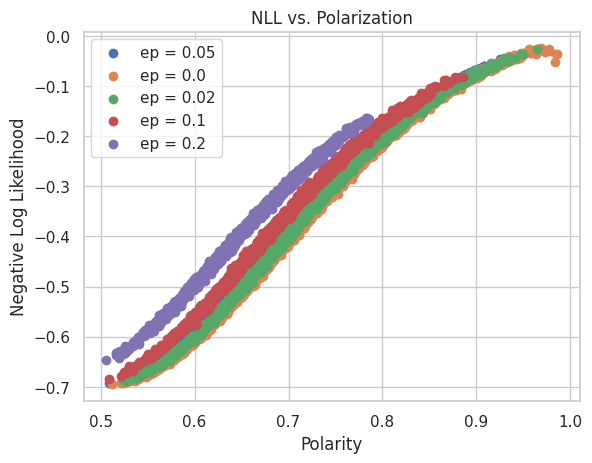

In [10]:
defaults = {
    "lex_size" : 10,
    'pop_size' : 10000,
    'alpha'    : 3,
    'beta'     : 3,
    'a_mult'   : 2,
    'scoring'  : 'neg_log_loss',
    'speech_len' : 15,
    'strength' : 2,
    'num_folds' : 5
}

sns.set(style="whitegrid")

for e in df['epsilon'].unique():
    condition = (df['epsilon'] == e)
    for key, value in defaults.items():
        condition &= (df[key] == value)

    ep = df[condition].dropna(subset=['rho','score'])

    if not ep.empty:
        x = ep['rho'].values.reshape(-1, 1)
        y = ep['score'].values
        plt.scatter(x, -y, label=f'ep = {e}')

plt.legend()
plt.xlabel('Polarity')
plt.ylabel('Negative Log Likelihood')
plt.title('NLL vs. Polarization')
plt.show()

This seems off...

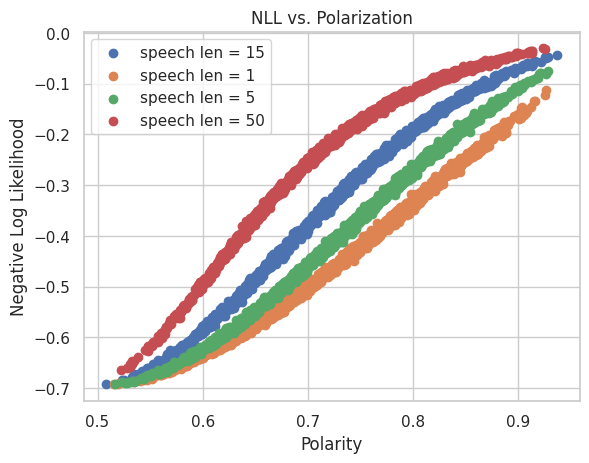

In [11]:
defaults = {
    "lex_size" : 10,
    'pop_size' : 10000,
    'epsilon' : .05,
    'alpha'    : 3,
    'beta'     : 3,
    'a_mult'   : 2,
    'scoring'  : 'neg_log_loss',
    'strength' : 2,
    'num_folds' : 5
}


sns.set(style="whitegrid")

for e in df['speech_len'].unique():
    condition = (df['speech_len'] == e)
    for key, value in defaults.items():
        condition &= (df[key] == value)

    ep = df[condition].dropna(subset=['rho','score'])

    if not ep.empty:
        x = ep['rho'].values.reshape(-1, 1)
        y = ep['score'].values
        plt.scatter(x, -y, label=f'speech len = {e}')

plt.legend()
plt.xlabel('Polarity')
plt.ylabel('Negative Log Likelihood')
plt.title('NLL vs. Polarization')
plt.show()

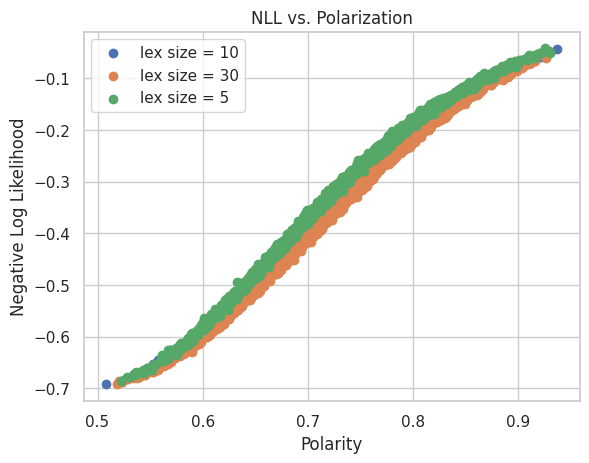

In [109]:
defaults = {
    'speech_len' : 15,
    'pop_size' : 10000,
    'epsilon' : .05,
    'alpha'    : 3,
    'beta'     : 3,
    'a_mult'   : 2,
    'scoring'  : 'neg_log_loss',
    'strength' : 2,
    'num_folds' : 5
}


sns.set(style="whitegrid")

for e in df['lex_size'].unique():
    condition = (df['lex_size'] == e)
    for key, value in defaults.items():
        condition &= (df[key] == value)

    ep = df[condition].dropna(subset=['rho','score'])

    if not ep.empty:
        x = ep['rho'].values.reshape(-1, 1)
        y = ep['score'].values
        plt.scatter(x, -y, label=f'lex size = {e}')

plt.legend()
plt.xlabel('Polarity')
plt.ylabel('Negative Log Likelihood')
plt.title('NLL vs. Polarization')
plt.show()

<Figure size 1200x800 with 0 Axes>

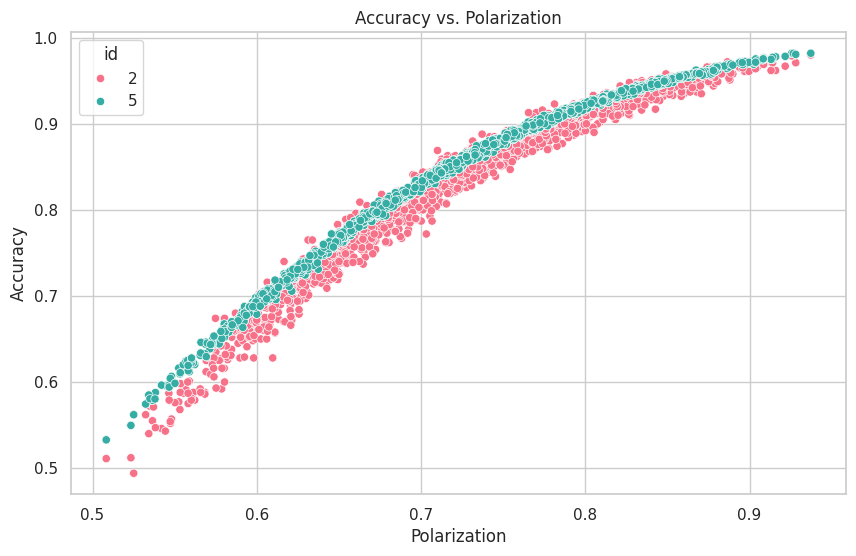

In [12]:
data = df[(df['scoring'] == 'accuracy')]
plot(data)

<Figure size 1200x800 with 0 Axes>

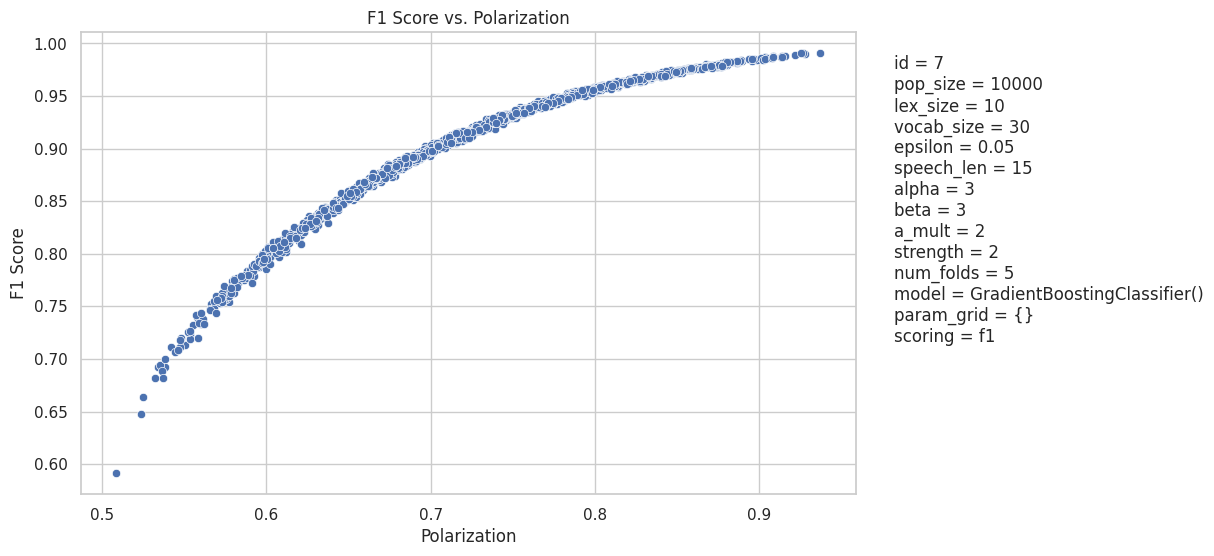

In [112]:
data = df[(df['scoring'] == 'f1')]
plot(data)